# Forest Cover Prediction

- **Class Section: 2019 Summer - Monday 6:30 PM**

- **Project Team: Adam Sohn, Curtis Lin, Erik Hou, Youzhi (Chloe) Wu**


***

## 1. Problem Motivation & Objective

### 1.1 Motivation

- In the United States, forests occupy approximately 740 million acres, about one third of the country's total land area. Forests support wildlife living among the trees, such as foxes, deer, coyotes, bats, hawks, bears, woodpeckers, many migratory birds etc.. Therefore, it is important to develop an method to effectively monitor and manage the forest changes. Here, we are developing an <font color=blue>**machine learning-based forest resource management**</font> which help improve forest productivity, increases bio-diversity, and protects wildlife. 


### 1.2 Objective

- The objective of this project is to establish a machine learning algorithm to effectively and accurately predict the forest canopy cover type by using cartographic variables only. The seed information for this project is a dataset provided by the US Forest Service (USFS) Region 2 Resource Information System. 


***

## 2. Dataset Description

- The seed information for this project is a dataset provided by the US Forest Service (USFS) Region 2 Resource Information System. The dataset describes 30x30 meter cells in four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

- The dataset contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.
The dataset also contains continuous, unscaled, quantitative data to describe independant variables such as elevation and distance from roads.

- Dataset: https://www.kaggle.com/c/forest-cover-type-prediction

***

## 3. Report Outline

1. We first performed basic EDA to explore data, noting irregularities and relationships between variables.
2. Next, we conducted baseline analysis on potential classification algorithms to hone in on most promising algorithm(s).
3. Based on our baseline study, we considered <font color=blue>**SVM (without normalization)**</font>, <font color=blue>**Random Forest**</font> and <font color=blue>**Decision Tree**</font> Classifiers as good candidates for our modeling improvement.   
4. We conducted first round of basic feature engineering, apply adaboost and/or bagging techniques to see if accuracies of these three classifiers could be improved or not, and also performed GridSearch to tune hyper-parameters of each model.  
5. Based on our error analysis of round 1 feature engineering, we conducted round 2 feature engineering, and passed through candidate classifiers. 
6. Based on our error analysis of round 2 feature engineering, we conducted round 3 feature engineering, and passed through candidate classifiers again.
7. Finally, we performed GridSearch to tune hyper-parameters of our best performer.
8. We submitted to Kaggle to obtain our test accuracy, as well as summarized findings and future improvements at the end of this report. 

***

## 4. Package Loading

In [1]:
%matplotlib inline

# General libraries
import csv
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import sklearn
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from collections import defaultdict
from numpy import genfromtxt

# SK-learn libraries for learning.
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# SK-learn model packages 
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import BaggingClassifier

# SK-learn libraries for evaluation.
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit

from sklearn.decomposition import PCA

import pandas as pd
pd.set_option('display.max_columns', None)

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

#### Python and package versions:

In [2]:
!python --version

Python 3.7.1


In [3]:
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("matplotlib version:", matplotlib.__version__)
print("sciKit-learn version:", sklearn.__version__)
print("seaborn version:", sns.__version__)
print("csv version:", csv.__version__)



NumPy version: 1.15.4
Pandas version: 0.23.4
matplotlib version: 3.0.2
sciKit-learn version: 0.20.1
seaborn version: 0.9.0
csv version: 1.0


***

## 5. Data Loading


In [4]:
# Colab library to upload files to notebook
from google.colab import files

ModuleNotFoundError: No module named 'google'

In [0]:
# Upload kaggle API key file
uploaded = files.upload()

Saving soil_feature.csv to soil_feature.csv


In [77]:
### Pandas dataframe for EDA, feature engineering

# train_raw_df = pd.read_csv("./forest-cover-type-prediction/train.csv")
train_raw_df = pd.read_csv("train.csv")
train_df = train_raw_df.loc[:,"Elevation":] #remove ID column from df
# test_df_no_label = pd.read_csv('./forest-cover-type-prediction/test.csv') # this dataframe is for final prediction

### Call this function after feature engineering on pandas dataframe to generate numpy array for train/dev split
def data_to_np(my_data=train_df.values):
    '''Takes numpy array as argument in order to return train/dev datasets 
    according to desired feature engineering. Default is no feature engineering.
    '''
    np.random.seed(0)
    data = my_data[:, :my_data.shape[1]-1]   
    labels = my_data[:,-1]
    
    shuffle = np.random.permutation(np.arange(data.shape[0]))

    shuffled_data = data[shuffle]
    shuffled_labels = labels[shuffle]
    shuffled_labels = shuffled_labels

    # split the data to 70% train and 30% dev 
    num_train = int(shuffled_data.shape[0]*0.7)

    train_data, train_labels = shuffled_data[:num_train], shuffled_labels[:num_train]
    dev_data, dev_labels = shuffled_data[num_train:], shuffled_labels[num_train:]
    train_labels = train_labels.astype('int')
    dev_labels = dev_labels.astype('int')
    
    return train_data, dev_data, train_labels, dev_labels

***

## 6. Baseline Analysis

### <font color=blue> 6-1. Basic Information and Descriptive Statistics</font>

**1. Check data shape**
> We note that there is Id column in the train_csv. Therefore, we need to remove this column before modeling. Cover_Type is our target variable for prediction. As a result, the train.csv contains 54 features, excluding Id and Cover_Type. 

In [6]:
print("\n### Features:\n")
print(train_raw_df.columns)
print("\nDimension of raw train data (train.csv):", train_raw_df.shape)


### Features:

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil

**2. Check distribution of cover types**
> In the train_csv, the cover types are equally divided into 7 categories. Therefore, in our modeling process, we do not need to preprocess our dataset or adjust class weights to account for skewness. 

In [7]:
# Count the number of instances of each class
print(train_df.groupby('Cover_Type').size())

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64


**3. Check column description**
> We categorize our features into the following groups, and check the basic description of each column. 
- Geographic information
- Hydrological information
- Distance to roadways and fire points
- Hillshade information
- Wilderness area information
- Soil information

In [8]:
# Geographic information

print("### Geographic information ### \n")
print(train_df.iloc[:,0:3].describe())

# Hydrological information

print("\n### Hydrological information ### \n")
print(train_df.iloc[:,3:5].describe())

# Distance to roadways and fire points

print("\n### Distance to roadways and fire points ### \n")
print(train_df.loc[:,['Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Fire_Points']].describe())

# Hillshade information (0 to 255 index) 

print("\n### Hillshade information (0 to 255 index) ### \n")
print(train_df.iloc[:,6:9].describe())

# Wilderness area information

print("\n### Wilderness area information ### \n")
print(train_df.iloc[:,10:14].describe())

### Geographic information ### 

          Elevation        Aspect         Slope
count  15120.000000  15120.000000  15120.000000
mean    2749.322553    156.676653     16.501587
std      417.678187    110.085801      8.453927
min     1863.000000      0.000000      0.000000
25%     2376.000000     65.000000     10.000000
50%     2752.000000    126.000000     15.000000
75%     3104.000000    261.000000     22.000000
max     3849.000000    360.000000     52.000000

### Hydrological information ### 

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology
count                      15120.000000                    15120.000000
mean                         227.195701                       51.076521
std                          210.075296                       61.239406
min                            0.000000                     -146.000000
25%                           67.000000                        5.000000
50%                          180.000000                       32.00

> From above description, we conclude that there is no missing value in our raw train data.

In [9]:
# Soil information (binary data)

train_df.iloc[:,14:54].describe()

,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357
std,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


> From above description of soil information, we notice that all records have zero value in Soil_Type7 and Soil_Type15. Therefore, we consider removing Soil_Type7 and Soil_Type15 as part of our data cleaning. 

In [10]:
# Dropping Soil_Type7 and Soil_Type15 from train_df
train_df = train_df.drop(['Soil_Type7', 'Soil_Type15'], axis = 1)
train_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


***

### <font color=blue> 6-2. Baseline Classifier Selection</font>

> In this section, we run through all potential classifiers without any feature engineering or hyper-parameter tuning in order to have an overall sense of classifier performances in our problem. From there, we select our candidate classifiers to penetrate through our problem.

#### 1.  Run through classifiers that do not require standard normalization of data

In [11]:
# Generate train_data, dev_data, train_labels, and dev_labels from raw dataset 
train_data, dev_data, train_labels, dev_labels = data_to_np(my_data=train_df.values)

# set seed for random state
seed = 0

# k-Nearest Neighbor Classifier

knn = KNeighborsClassifier()
knn.fit(train_data, train_labels)
knn_pred = knn.predict(dev_data)
knn_train_score = accuracy_score(train_labels, knn.predict(train_data))
knn_score = accuracy_score(dev_labels, knn_pred)

print("# k-Nearest Neighbor Classifier as Base Model:\n")
print("Training accuracy score: %0.4f" %knn_train_score)
print("Dev data accuracy score: %0.4f" %knn_score)
print("-"*70)

# Gaussian Naive Bayes Classifier

gnb = GaussianNB()
gnb.fit(train_data, train_labels)
gnb_pred = gnb.predict(dev_data)
gnb_train_score = accuracy_score(train_labels, gnb.predict(train_data))
gnb_score = accuracy_score(dev_labels, gnb_pred)

print("\n# Gaussian Naive Bayes Classifier as Base Model:\n")
print("Training accuracy score: %0.4f" %gnb_train_score)
print("Accuracy score: %0.4f" %gnb_score)
print("-"*70)

# Logistic Regression Classifier

lr = LogisticRegression()
lr.fit(train_data, train_labels)
lr_pred = lr.predict(dev_data)
lr_train_score = accuracy_score(train_labels, lr.predict(train_data))
lr_score = accuracy_score(dev_labels, lr_pred)

print("\n# Logistic Regression Classifier as Base Model:\n")
print("Training accuracy score: %0.4f" %lr_train_score)
print("Accuracy score: %0.4f" %lr_score)
print("-"*70)

# Decision Tree Classifier

dt = DecisionTreeClassifier(random_state=seed)
dt.fit(train_data, train_labels)
dt_pred = dt.predict(dev_data)
dt_train_score = accuracy_score(train_labels, dt.predict(train_data))
dt_score = accuracy_score(dev_labels, dt_pred)

print("\n# Decision Tree Classifier as Base Model:\n")
print("Training accuracy score: %0.4f" %dt_train_score)
print("Accuracy score: %0.4f" %dt_score)
print("-"*70)

# Random Forest Classifier

rf = RandomForestClassifier(random_state=seed)
rf.fit(train_data, train_labels)
rf_pred = rf.predict(dev_data)
rf_train_score = accuracy_score(train_labels, rf.predict(train_data))
rf_score = accuracy_score(dev_labels, rf_pred)

print("\n# Random Forest Classifier as Base Model:\n")
print("Training accuracy score: %0.4f" %rf_train_score)
print("Accuracy score: %0.4f" %rf_score)
print("-"*70)

# k-Nearest Neighbor Classifier as Base Model:

Training accuracy score: 0.8717
Dev data accuracy score: 0.7919
----------------------------------------------------------------------

# Gaussian Naive Bayes Classifier as Base Model:

Training accuracy score: 0.5916
Accuracy score: 0.5983
----------------------------------------------------------------------

# Logistic Regression Classifier as Base Model:

Training accuracy score: 0.6691
Accuracy score: 0.6638
----------------------------------------------------------------------

# Decision Tree Classifier as Base Model:

Training accuracy score: 1.0000
Accuracy score: 0.7923
----------------------------------------------------------------------

# Random Forest Classifier as Base Model:

Training accuracy score: 0.9948
Accuracy score: 0.8208
----------------------------------------------------------------------


#### 2. Run through classifier that requires standard normalization of data (Support Vector Machine)

> SVMs assume the data is in a standard range which is usually either 0 to 1, or -1 to 1. Therefore, we first performed normalization of feature vectors prior to feeding them to the SVM. 

In [12]:
# Perform standard normalization of data

# Seperate continuous and discrete variables from raw train_data 
# train_raw_df_ID = train_raw_df.iloc[:,0]
train_df_cont = train_df.iloc[:,:11]
train_df_disc = train_df.iloc[:,11:52]
train_df_cover = train_df.iloc[:,52]

# normalize continuous variables of training data 
train_df_cont_norm = preprocessing.normalize(train_df_cont)
train_df_cont_norm = pd.DataFrame(train_df_cont_norm)
train_df_cont_norm.columns = train_df_cont.columns.values
train_df_cont_norm.index = train_df_cont.index.values

# combine normalized continuous variable and binary variable of training data 
train_df_norm = pd.concat([train_df_cont_norm, train_df_disc, train_df_cover], 
                          axis = 1)
train_df_norm.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,0.380210,0.007469,0.000439,0.037787,0.000000,0.074695,0.032368,0.033979,0.021676,0.919622,0.000146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,0.382769,0.008276,0.000296,0.031331,-0.000887,0.057637,0.032513,0.034730,0.022316,0.919975,0.000148,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,0.375821,0.018630,0.001206,0.035920,0.008712,0.426216,0.031363,0.031899,0.018094,0.820399,0.000134,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,0.371810,0.020693,0.002403,0.032308,0.015754,0.412529,0.031774,0.031774,0.016288,0.829196,0.000134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,0.386275,0.006698,0.000298,0.022775,-0.000149,0.058202,0.032748,0.034832,0.022328,0.918725,0.000149,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [0]:
# Generate train_data, dev_data, train_labels, and dev_labels from normalized dataset 
train_data_norm, dev_data_norm, train_labels, dev_labels = data_to_np(my_data = train_df_norm.values)

seed = 0

In [0]:
# Support Vector Machine Classifier

svmc = svm.SVC(random_state=seed, gamma='scale')
svmc.fit(train_data_norm, train_labels)
svmc_pred = svmc.predict(dev_data_norm)
svmc_train_score = accuracy_score(train_labels, svmc.predict(train_data_norm))
svmc_score = accuracy_score(dev_labels, svmc_pred)

print("\n#  Support Vector Machine Classifier using Normalized Data:")
print("Training accuracy score: %0.4f" %svmc_train_score)
print("Accuracy score: %0.4f" %svmc_score)
print("-"*70)

print("\n# 3. Confusion_matrix")
print(confusion_matrix(dev_labels, svmc_pred))


#  Support Vector Machine Classifier using Normalized Data:
Training accuracy score: 0.6438
Accuracy score: 0.6519
----------------------------------------------------------------------

# 3. Confusion_matrix
[[310 226   3   0  44   5  69]
 [108 413  14   2  86  24   7]
 [  0   2 366  95  21 149   0]
 [  0   0  39 569   0  71   0]
 [ 64  93  44   0 433  19   0]
 [  5  25 119  79  49 346   0]
 [ 61  47   4   0   5   0 520]]


#### 3. Run through SVM classifier without standard normalization of data

> We notice that the accuracy score of using normalized data is not high. We now try using un-normalized raw data, and check SVM performance again.

In [0]:
# Generate train_data, dev_data, train_labels, and dev_labels from un-normalized dataset 
train_data, dev_data, train_labels, dev_labels = data_to_np(my_data = train_df.values)

seed = 0

In [0]:
# Support Vector Machine Classifier

svmc2 = svm.SVC(random_state=seed, gamma='scale')
svmc2.fit(train_data, train_labels)
svmc2_pred = svmc2.predict(dev_data)
svmc2_train_score = accuracy_score(train_labels, svmc2.predict(train_data))
svmc2_score = accuracy_score(dev_labels, svmc2_pred)

print("\n#  Support Vector Machine Classifier using Un-Normalized Data:")
print("Training accuracy score: %0.4f" %svmc2_train_score)
print("Accuracy score: %0.4f" %svmc2_score)
print("-"*70)

print("\n# 3. Confusion_matrix")
print(confusion_matrix(dev_labels, svmc2_pred))


#  Support Vector Machine Classifier using Un-Normalized Data:
Training accuracy score: 0.6328
Accuracy score: 0.6378
----------------------------------------------------------------------

# 3. Confusion_matrix
[[380  86   0   0  51   2 138]
 [148 275  17   0 164  32  18]
 [  0  12 262 115  31 213   0]
 [  0   0 101 533   0  45   0]
 [  5  85   6   0 532  25   0]
 [  0   2 170  85  47 319   0]
 [ 41   4   0   0   0   0 592]]


> We notice that using un-normalized data to feed SVM in fact yields much better accuracy, which is in contrast to our initial view on SVM. From the feature importance ranking in Section 7.2, we see that **Elevation** which has a larger magnitude of value ranks as the top feature. Therefore, we suspect that without normalization, **Elevation** poses a greater weight in forming the decision boundary which makes the un-normalized version yielding a better result. 

***

### <font color=blue> 6-3. Conclusion and Error Analysis of Baseline Round</font>

> Below is a summary of our baseline accuracies:
- k-Nearest Neighbor Classifier: 0.7919 
- Gaussian Naive Bayes Classifier: 0.5983
- Logistic Regression Classifier: 0.6759
- Decision Tree Classifier: `0.7923`
- Random Forest Classifier: `0.8208`
- Support Vector Machine Classifier using normalized data: 0.6232
- Support Vector Machine Classifier using un-normalized data: `0.8488`

> From above accuracy results, we consider <font color=blue>**SVM (without normalization)**</font>, <font color=blue>**Random Forest**</font> and <font color=blue>**Decision Tree**</font> Classifiers as good candidates for our modeling. In following sections, we plan to:  
- (1). Conduct first round of basic feature engineering, apply adaboost and/or bagging techniques to see if accuracies of these three classifiers could be improved or not, and perform GridSearch to tune hyper-parameters of each model.  
- (2). Based on our error analysis of round 1 feature engineering, conduct round 2 feature engineering, and pass through candidate classifiers. 
- (3). Based on our error analysis of round 2 feature engineering, conduct round 3 feature engineering, and pass through candidate classifiers again.
- (4). Finally, perform GridSearch to tune hyper-parameters of candidate classifiers.

***

## 7. Feature Engineering and Sensible Methods

### <font color=blue> 7-1. Feature Information</font>

> - Elevation - Elevation in meters
- Aspect - Aspect in degrees azimuth
- Slope - Slope in degrees
- Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
- Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
- Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation. Soil_Type7 and Soil_Type15 are dropped in our data cleaning stage.
- Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

***

### <font color=blue> 7-2. Feature Engineering Strategies </font>
In this section, by 
- applying Random Forest Regressor to rank the importance score of each feature, and
- analyzing correlation matrix

We establish our feature engineering strategies on variable transformation, interaction, and feature reduction.

In [13]:
my_data = train_df.values
train_data, dev_data, train_labels, dev_labels = data_to_np(my_data)
seed = 0

# Rank feature importance based off Random Forest Regressor results
names = train_df.columns.values
rf = RandomForestRegressor(random_state=seed)
rf.fit(train_data, train_labels)
print("Features sorted by their score:")
for elem in sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True):
    print(elem)

Features sorted by their score:
(0.4151, 'Elevation')
(0.09, 'Horizontal_Distance_To_Roadways')
(0.0801, 'Horizontal_Distance_To_Fire_Points')
(0.0445, 'Horizontal_Distance_To_Hydrology')
(0.0414, 'Vertical_Distance_To_Hydrology')
(0.041, 'Soil_Type39')
(0.0357, 'Aspect')
(0.0335, 'Hillshade_9am')
(0.0335, 'Hillshade_3pm')
(0.0324, 'Hillshade_Noon')
(0.0272, 'Slope')
(0.0222, 'Soil_Type38')
(0.012, 'Soil_Type12')
(0.0114, 'Soil_Type32')
(0.0099, 'Wilderness_Area3')
(0.0089, 'Soil_Type35')
(0.0073, 'Wilderness_Area1')
(0.0068, 'Soil_Type10')
(0.0046, 'Soil_Type22')
(0.004, 'Soil_Type13')
(0.0038, 'Soil_Type29')
(0.0032, 'Soil_Type4')
(0.0029, 'Soil_Type31')
(0.0028, 'Soil_Type30')
(0.0027, 'Soil_Type40')
(0.0027, 'Soil_Type33')
(0.0023, 'Soil_Type23')
(0.0021, 'Soil_Type24')
(0.002, 'Soil_Type2')
(0.0017, 'Wilderness_Area2')
(0.0017, 'Soil_Type20')
(0.0017, 'Soil_Type11')
(0.0014, 'Soil_Type3')
(0.0013, 'Wilderness_Area4')
(0.001, 'Soil_Type17')
(0.0008, 'Soil_Type1')
(0.0007, 'Soil_Typ

> Our feature engineering effort will focus on top 10 features, where each variable explains > 3% of variability: 
- 'Elevation', 
- 'Horizontal_Distance_To_Roadways', 
- 'Horizontal_Distance_To_Fire_Points', 
- 'Horizontal_Distance_To_Hydrology', 
- 'Soil_Type39',
- 'Vertical_Distance_To_Hydrology', 
- 'Aspect',  
- 'Hillshade_3pm', 
- 'Hillshade_9am', 
- 'Hillshade_Noon'

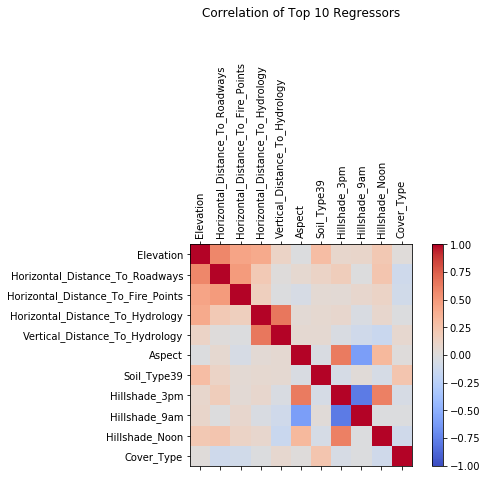

In [14]:
def generate_cor_graph(data, size=(8,6), title = None):
    
    corr = data.corr()
    fig = plt.figure(figsize = size)
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(data.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(data.columns)
    ax.set_yticklabels(data.columns)
    plt.tight_layout()
    plt.title(title, y=2)    
    plt.show()
    
generate_cor_graph(train_df[['Elevation', 'Horizontal_Distance_To_Roadways', 
                             'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 
                             'Vertical_Distance_To_Hydrology', 'Aspect', 'Soil_Type39', 
                             'Hillshade_3pm', 'Hillshade_9am', 'Hillshade_Noon','Cover_Type']], 
                   title = 'Correlation of Top 10 Regressors')

> From the correlation heatmap we can see that 
- **Elevation** is highly correlated with several other variables, such as:
    - Horizontal_Distance_To_Hydrology
    - Horizontal_Distance_To_Roadways
    - Hillshade_Noon
    - Horizontal_Distance_To_Fire_Points
- **Aspect** is highly correlated with the following variables:
    - Hillshade_9am
    - Hillshade_Noon
    - Hillshade_3pm
- **Horizontal_Distance_To_Hydrology** is highly correlated with the following variables:
    - Vertical_Distance_To_Hydrology
- **Horizontal_Distance_To_Roadways** is highly correlated with the following variables:
    - Horizontal_Distance_To_Fire_Points
- **Hillshade_9am** is highly negatively correlated with the following variables:
    - Hillshade_3pm
- **Hillshade_Noon** is highly positively correlated with the following variables:
    - Hillshade_3pm

> From our research on domain knowledge, we found that **Hillshade** is a function of elevation, slope, and aspect: 
$Hillshade = 255.0 * \left[ \cos \left[(90 - Altitude)\frac{\pi}{180}\right] \cos(Slope) + \sin\left[(90 - Altitude)\frac{\pi}{180}\right] \sin(Slope) \cos(Azimuth - Aspect) \right]$

> Based off our above analysis, we could transform certain highly important variables, create interaction variables among correlated variables, and conduct feature reduction using PCA to decrease correlation and minimize overfitting. 

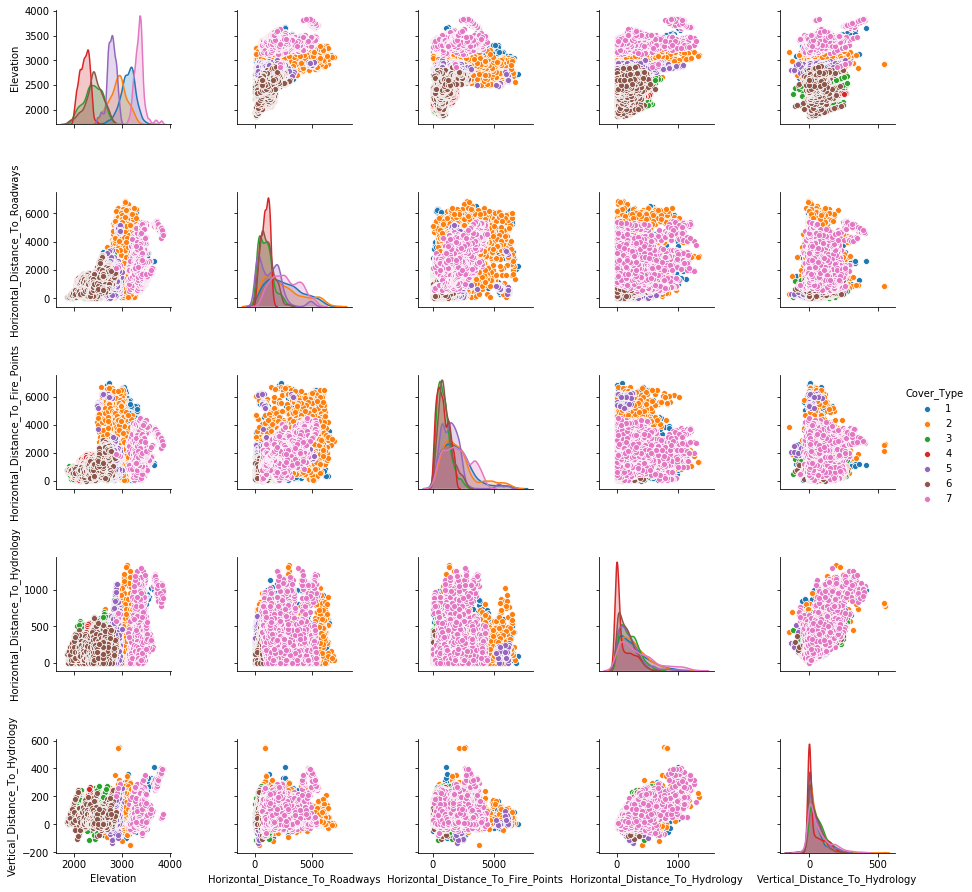

In [15]:
# Plot pairplot between cover type and important variables (based off the RF regressor ranking. Limited to top 6)
sns.pairplot(train_df, hue='Cover_Type', vars=['Elevation', 
                                               'Horizontal_Distance_To_Roadways', 
                                               'Horizontal_Distance_To_Fire_Points', 
                                               'Horizontal_Distance_To_Hydrology', 
                                               'Vertical_Distance_To_Hydrology', 
                                               ])

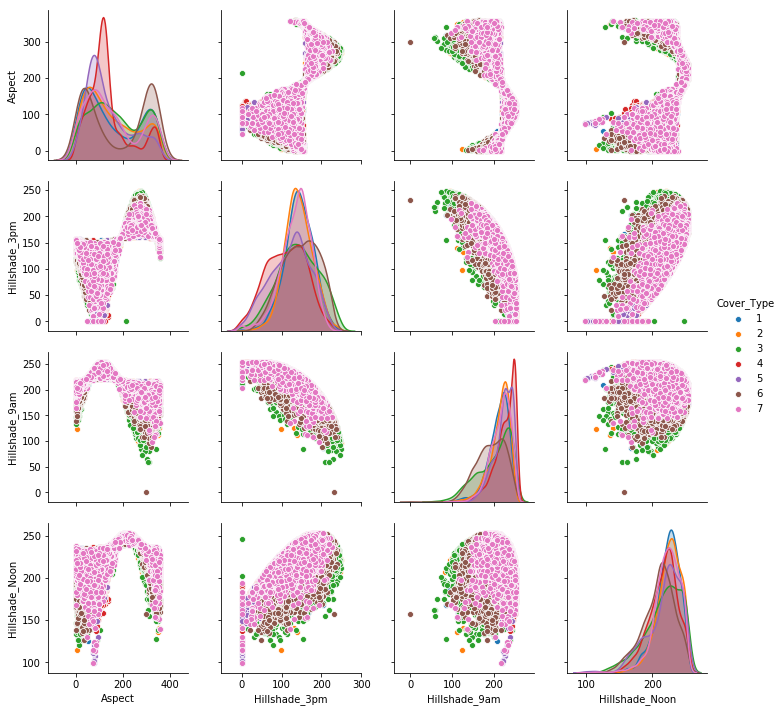

In [16]:
sns.pairplot(train_df, hue='Cover_Type', vars=['Aspect', 'Hillshade_3pm', 'Hillshade_9am', 'Hillshade_Noon'])

> Taking stock of pairplots of highly-correlated features, none show a clear separation of Cover Types with only **Elevation** and **Aspect** show limited degree of class separation. Still, the following transformations were attempted, which did not yield accuracy improvements:
* Combining **Horizontal_Distance_To_Hydrology** and **Vertical_Distance_To_Hydrology** using Pythagorean Theorem for non-vector distance to hydrology.
* Splitting **Vertical_Distance_To_Hydrology** to **Highwater (Positive)** and **Lowwater (Negative)** to note areas that are likely wetter.

***

### <font color=blue> 7-3. Feature Engineering Round 1: Variable Categorization </font>

#### 1. Plot histogram & pairplot of continuous variables to see if can categorize certain variables

> - We first separate our train_df (train.csv without Id, Soil_Typ7 & Soil_Type15 columns) into two dataframes with continuous and discrete variables respectively. 
- Plot the histogram of continuous variables to see if we can categorize certain variables. Specifically, we would like to focus on **Elevation** and **Aspect** variables which shows certain degree of class separation.

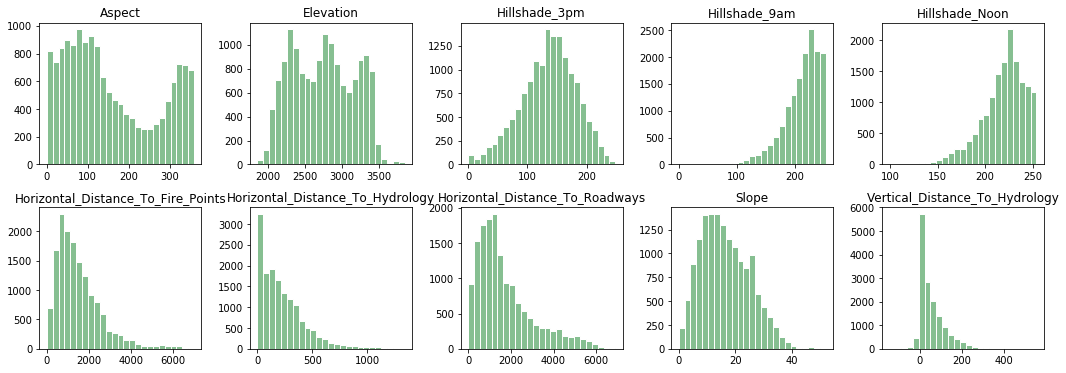

In [46]:
# Separate continuous variables and discrete variables from train_df
train_df_cont_noLabel = train_df.iloc[:,:10]
train_df_disc_noLabel = train_df.iloc[:,10:52]
train_df_cover = train_df.iloc[:,52]

train_df_cont = pd.concat([train_df_cont_noLabel, train_df_cover], axis = 1)
train_df_disc = pd.concat([train_df_disc_noLabel, train_df_cover], axis = 1)

# Plot histogram of each continuous variable to see if can categorize certain variables
train_df_cont.iloc[:,:10].hist(bins=25, grid=False, color='#86bf91', edgecolor='white', 
                               layout=(2,5), figsize=(18,6))
plt.show()

> From above histograms, we can see that the distribution of **Aspect** and **Elevation** variables show certain degree of separation. 
- Two peaks identified in **Aspect** histogram;
- Three peaks identified in **Elevation** histogram. 

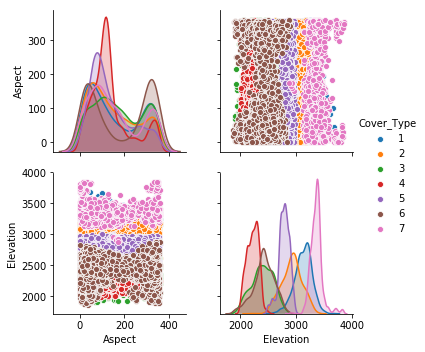

In [0]:
# Plot pairplot between cover type and Aspect/Elevation variables
sns.pairplot(train_df, hue='Cover_Type', vars=['Aspect', 'Elevation'])

> We plot the pairplot between Aspect and Elevation categorized by cover type, we see certain degree of class separation:
- Type 4 and 6 are well separated by Aspect;
- Type 1, 2, 3, 4 and 6 are overlapped in terms of Aspect;
- Type 4, 5 and 7 are well separated by Elevation;
- Type 1 and 3 are well separated by Elevation;
- Type 1 and 6 are well separated by Elevation;
- Type 3 and 2 are somewhat separated by Elevation;
- Type 1 and 2 are overlapped in terms of Elevation, with only a relatively small degree of separation. 

> Therefore, we plan to introduce new categorical variables for Aspect and Elevation to amplify the class separation caused by these two variables. 

#### 2. Create buckets for Aspect and Elevation
>- **Aspect**: group 1 = [0, 200], group 2 = [200,max]
- **Elevation**: group 1 = [0, 2600], group 2 = [2600, 3000], and group 3 = [3000,max]

In [0]:
# Check on the mean of Apect & Elevation of different cover type to decide on how to bucketize 
train_df.groupby('Cover_Type').agg({'Aspect':'mean', 'Elevation':'mean'})

,Aspect,Elevation
Cover_Type,,
1,159.463426,3128.025926
2,151.097222,2922.540278
3,173.672685,2398.423148
4,138.099537,2223.420370
5,137.992130,2786.801389
6,180.617130,2423.276852
7,155.794444,3362.769907


In [47]:
### Begin Feature Engineering
# Separate continuous variables and discrete variables from train_df
train_df_cont_noLabel = train_df.iloc[:,:10]
train_df_disc_noLabel = train_df.iloc[:,10:52]
train_df_cover = train_df.iloc[:,52]

# 1. Add new categorical variable for aspect to train_df_disc_noLabel
labels_aspect = [1, 2]
train_df_cont_noLabel['Aspect_Group'] = pd.cut(train_df_cont_noLabel.Aspect, [0, 200, 360], 
                                               labels=labels_aspect, include_lowest=True)

# 2. Add new categorical variable for elevation to train_df_disc_noLabel
labels_elevation = [1, 2, 3]
train_df_cont_noLabel['Elevation_Group'] = pd.cut(train_df_cont_noLabel.Elevation, [0, 2600, 3000, 3900], 
                                                  labels=labels_elevation, include_lowest=True)


# 3. Concatenate df from step 1, df from step 2, and train_df_cover to generate new df for algo
train_df_engineered1 = pd.concat([train_df_cont_noLabel, train_df_disc_noLabel, train_df_cover], axis = 1)

display(train_df_engineered1.head())


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Aspect_Group,Elevation_Group,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


#### 3. Create train and dev numpy arrays for model evaluation

In [48]:
# Create new train_data and dev_data after this round of feature engineering 
my_data = train_df_engineered1.values
train_data, dev_data, train_labels, dev_labels = data_to_np(my_data)

seed = 0

#### 4. Pass through candidate classifiers to check improvement after round 1 feature engineering 

In [0]:
# Decision Tree Classifier

dt = DecisionTreeClassifier(random_state=seed)
dt.fit(train_data, train_labels)
dt_pred = dt.predict(dev_data)
dt_train_score = accuracy_score(train_labels, dt.predict(train_data))
dt_score = accuracy_score(dev_labels, dt_pred)

print("\n# Decision Tree Classifier with round 1 feature engineering:\n")
print("Training Accuracy score: %0.4f" %dt_train_score)
print("Dev Data Accuracy score: %0.4f" %dt_score)
print("-"*70)

# Random Forest Classifier

rf = RandomForestClassifier(random_state=seed)
rf.fit(train_data, train_labels)
rf_pred = rf.predict(dev_data)
rf_train_score = accuracy_score(train_labels, rf.predict(train_data))
rf_score = accuracy_score(dev_labels, rf_pred)

print("\n# Random Forest Classifier with round 1 feature engineering:\n")
print("Training Accuracy score: %0.4f" %rf_train_score)
print("Dev Data Accuracy score: %0.4f" %rf_score)
print("-"*70)

# Support Vector Machine Classifier

svmc = svm.SVC(random_state=seed, gamma='scale')
svmc.fit(train_data, train_labels)
svmc_pred = svmc.predict(dev_data)
svm_train_score = accuracy_score(train_labels, svmc.predict(train_data))
svmc_score = accuracy_score(dev_labels, svmc_pred)

print("\n#  Support Vector Machine Classifier using Un-Normalized Data with round 1 feature engineering:\n")
print("Training Accuracy score: %0.4f" %svm_train_score)
print("Dev Data Accuracy score: %0.4f" %svmc_score)
print("-"*70)


# Decision Tree Classifier with round 1 feature engineering:

Training Accuracy score: 1.0000
Dev Data Accuracy score: 0.7897
----------------------------------------------------------------------

# Random Forest Classifier with round 1 feature engineering:

Training Accuracy score: 0.9945
Dev Data Accuracy score: 0.8302
----------------------------------------------------------------------

#  Support Vector Machine Classifier using Un-Normalized Data with round 1 feature engineering:

Training Accuracy score: 0.6327
Dev Data Accuracy score: 0.6373
----------------------------------------------------------------------


#### 5. Apply bagging and adaboost techniques

> In this section, we apply bagging to SVM and adaboost to Decision Tree to see if their performances could be beef up. 

In [0]:
# Bagging with SVM Classifier

clf = svm.SVC(random_state=seed, gamma = 'scale')
svm_bagger = BaggingClassifier(base_estimator=clf, random_state=seed).fit(train_data, train_labels)
bagger_pred = svm_bagger.predict(dev_data)
svmb_train_score = accuracy_score(train_labels, svm_bagger.predict(train_data))
bagger_score = accuracy_score(dev_labels, bagger_pred)

print("\n# Bagging using SVM Classifier with round 1 feature engineering:\n")
print("Training Accuracy score: %0.4f" %svmb_train_score)
print("Dev Accuracy score: %0.4f" %bagger_score)
print("-"*70)


# Bagging using SVM Classifier with round 1 feature engineering:

Training Accuracy score: 0.6326
Dev Accuracy score: 0.6371
----------------------------------------------------------------------


In [0]:
# Adaboost with Decision Tree Classifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15), n_estimators = 100, learning_rate = 0.5)
ada_clf.fit(train_data, train_labels)
ada_pred = ada_clf.predict(dev_data)
ada_train_score = accuracy_score(train_labels, ada_clf.predict(train_data))
ada_dev_score = accuracy_score(dev_labels, ada_pred)

print("\n# Adaboost with Decision Tree Classifier with round 1 feature engineering:\n")
print("Training Accuracy score: %0.4f" %ada_train_score)
print("Dev Data Accuracy score: %0.4f" %ada_dev_score)
print("-"*70)


# Adaboost with Decision Tree Classifier with round 1 feature engineering:

Training Accuracy score: 1.0000
Dev Data Accuracy score: 0.8624
----------------------------------------------------------------------


> Based on our bagging and adaboost results, we see that Adaboost with Decision Tree produces high improvement in accuracy, whereas bagging with SVM actually decreases accuracy. Path forward, we will apply Adaboost to Decision Tree. 

#### 6. Perform hyper-parameter tuning
> We perform a grid search over the hyper-parameters of Random Forest classifier, Adaboost of Decision Tree as well as SVM classifier. 

- <font color=blue>**Hyper-parameter tuning of Random Forest classifier**</font>
> <font color=red> We perform a grid search over n_estimators, maximum number of features considered at each split and the max depth of each tree, and find that
    - The best n_estimators is 200
    - The best max_features is 20
    - The max_depth is 70
    - We would use these parameters path forward.
   

In [22]:
# perform small set of hyperparameter tuning
param_grid = {
    'max_depth': [70, 80, 90, 100, None],
    'max_features': [10, 20, 30],
    'n_estimators': [50, 100, 200, 500]
}
# Create a based model
rfc = RandomForestRegressor(random_state=seed)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search.fit(train_data, train_labels)
grid_search.best_params_

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  2.3min finished


{'max_depth': 70, 'max_features': 20, 'n_estimators': 200}

In [49]:
# Random Forest Classifier

rf = RandomForestClassifier(random_state=seed, max_depth=70, max_features=20, n_estimators=500)
rf.fit(train_data, train_labels)
rf_pred = rf.predict(dev_data)
rf_train_score = accuracy_score(train_labels, rf.predict(train_data))
rf_score = accuracy_score(dev_labels, rf_pred)

print("\n# Random Forest Classifier with round 1 feature engineering:\n")
print("Training Accuracy score: %0.4f" %rf_train_score)
print("Dev Data Accuracy score: %0.4f" %rf_score)
print("-"*70)


# Random Forest Classifier with round 1 feature engineering:

Training Accuracy score: 1.0000
Dev Data Accuracy score: 0.8624
----------------------------------------------------------------------


- <font color=blue>**Hyper-parameter tuning of Adaboost of Decision Tree classifier**</font>
> <font color=red> </font> We perform a grid search over n_estimators and learning_rate hyper-parameters of Adaboost of Decision Tree classifier with max depth equal to 15, and find that
    - The best n_estimators is 500
    - The best learning_rate is 0.1
    - We would use these parameters path forward.

In [21]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.5, 0.25, 0.1]
}
# Create a based model
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15, max_features=20))

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = ada_clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search.fit(train_data, train_labels)
grid_search.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.1s finished


{'learning_rate': 0.05, 'n_estimators': 100}

In [33]:
# Adaboost with Decision Tree Classifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15), n_estimators = 500, learning_rate = 0.1)
ada_clf.fit(train_data, train_labels)
ada_pred = ada_clf.predict(dev_data)
ada_train_score = accuracy_score(train_labels, ada_clf.predict(train_data))
ada_dev_score = accuracy_score(dev_labels, ada_pred)

print("\n# Adaboost with Decision Tree Classifier with round 1 feature engineering:\n")
print("Training Accuracy score: %0.4f" %ada_train_score)
print("Dev Data Accuracy score: %0.4f" %ada_dev_score)
print("-"*70)


# Adaboost with Decision Tree Classifier with round 1 feature engineering:

Training Accuracy score: 0.9991
Dev Data Accuracy score: 0.8466
----------------------------------------------------------------------


- <font color=blue>**Hyper-parameter tuning of SVM classifier**</font>
> We perform a grid search over C and gamma hyper-parameters of SVM classifier, and find that
    - The best C is 10
    - The best gamma is 'scale'
    - We would use these parameters path forward.

In [0]:
seed = 0
# Initiate a set of hyperparameters for tuning
C_list = [0.001, 0.01, 0.1, 1, 10, 1000]
gamma_list = [0.01, 0.1, 1, 10, 'auto', 'scale']
param_grid = {'C': C_list, 'gamma': gamma_list}

# Create a base model
clf = svm.SVC(kernel = 'rbf', random_state=seed) 

# Grid search
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           cv=5, n_jobs=2, verbose = 2)
grid_search.fit(train_data, train_labels)
print("Best hyperparameters from grid search:")
print("-"*70)
print(grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [0]:
# Create a SVM classifier using best hyperparameters from grid search
best_svm = svm.SVC(kernel='rbf', C=10, gamma='scale', random_state=seed).fit(train_data, train_labels) 
svm_train_score = accuracy_score(train_labels, best_svm.predict(train_data))
svm_pred = best_svm.predict(dev_data)
svm_score = accuracy_score(dev_labels, svm_pred)

print("\n# Random Forest Classifier using best hyperparameters from grid search:\n")
print("Training Accuracy score: %0.4f" %svm_train_score)
print("Dev Data Accuracy score: %0.4f" %svm_score)
print("-"*70)


# Random Forest Classifier using best hyperparameters from grid search:

Training Accuracy score: 0.6862
Dev Data Accuracy score: 0.6854
----------------------------------------------------------------------


#### 7. Perform error analysis on selected model using confusion matrix 

In [0]:
print("\n# 1. Confusion_matrix of Random Forest:")
print(confusion_matrix(dev_labels, rf_pred))

print("\n# 2. Confusion_matrix of SVM:")
print(confusion_matrix(dev_labels, svm_pred))

print("\n# 3. Confusion_matrix of Adaboost of Decision Tree:")
print(confusion_matrix(dev_labels, ada_pred))


# 1. Confusion_matrix of Random Forest:
[[483 104   1   0  19   2  48]
 [111 449  15   0  56  17   6]
 [  0   2 513  26  11  81   0]
 [  0   0   8 662   0   9   0]
 [  1  11   6   0 627   8   0]
 [  0   1  44  14   1 563   0]
 [ 25   0   0   0   1   0 611]]

# 2. Confusion_matrix of SVM:
[[409 101   0   0  36   2 109]
 [143 297  21   0 145  34  14]
 [  0   1 286  81  34 231   0]
 [  0   0  49 584   0  46   0]
 [  4  51  14   0 569  15   0]
 [  0   2 161  59  30 371   0]
 [ 40   0   0   0   4   0 593]]

# 3. Confusion_matrix of Adaboost of Decision Tree:
[[480 124   0   0  11   1  41]
 [112 476   9   0  33  19   5]
 [  0   3 512  24   9  85   0]
 [  0   0  15 656   0   8   0]
 [  1  24   8   0 613   7   0]
 [  0   2  48   9   2 562   0]
 [ 23   0   0   0   1   0 613]]


#### 8. Conclusion & Error Analysis from Round 1 feature engineering
> Below is a table summarizing the best accuracy scores (with tuning) we achieved on dev data in round 1:

|        Model       |Random Forest| SVM      |DT w/ Adaboost|
|--------------------|------------:|---------:|-------------:|
|Round 1 Result      |0.8616      |0.8611    |0.8624        |
|Compared to Baseline|+4.08%       |+1.23%    |+7.01%        |

> - Based off the confusion matrices, we see that 
   - Cover Type 1 and 2 are hard to distinguish among all classifiers;
   - Next is Cover Type 3 and 6;
   - Therefore, in our next round of feature engineering, we would gear our engineering to amplify the separation of Cover Type 1 and 2, as well as Type 3 and 6.

***

### <font color=blue> 7-4. Feature Engineering Round 2: Adding New Soil Characteristics </font>

#### 1. Transform soil_type columns based off their geographical characteristics 
> New soil characteristics include: 'Rock outcrop', 'Rock Land',
        'Stony', 'Rubbly', 'Cyraquolls', 'Cryumbrepts',
       'Cryorthents', 'Leighcan', 'Till substratum', 'Catmount', 'Legault',
       'Moran', 'Bullwark', 'Crayaquepts', 'Vanet', 'Como'.

In [0]:
#Import data of featurizer table
# soil_feature = pd.read_csv('./forest-cover-type-prediction/soil_feature.csv')
soil_feature = pd.read_csv('soil_feature.csv')

#Establish dataframes as deep copies
train_df2 = train_df.copy(deep= True)

#Aggregating soil types in train_df2 and test_df2 for use as merge index
soil_cols = ['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19',
       'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23',
       'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27',
       'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31',
       'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
       'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type40']
train_df2['Soil_Type'] = train_df2[soil_cols].idxmax(axis=1)

#Merging train_df2 and test_df2 with soil_feature
train_df2 = train_df2.merge(soil_feature, how = 'left', on = 'Soil_Type')

#Manually reordering columns on train_df2 to make 'Cover_Type' at the end of the list.  
#Note this is not necessary for test2_df due to absence of 'Cover_Type' column. 
#Also eliminating 'Soil_Type' columns.
reordered_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Rock outcrop', 'Rock Land',
        'Stony', 'Rubbly', 'Cyraquolls', 'Cryumbrepts',
       'Cryorthents', 'Leighcan', 'Till substratum', 'Catmount', 'Legault',
       'Moran', 'Bullwark', 'Crayaquepts', 'Vanet', 'Como', 'Cover_Type']
train_df2 = train_df2[reordered_cols]

#### 2. Plot histograms of cover type 1 and 2 based off new  soil features
> As concluded from our round 1 feature engineering, we see that classifying cover type 1 and 2 is a challenge to our classifiers. Next, we would like to investigate the differences in soil characteristics of type 1 and 2, and from there we conduct our round 2 feature engineering. 

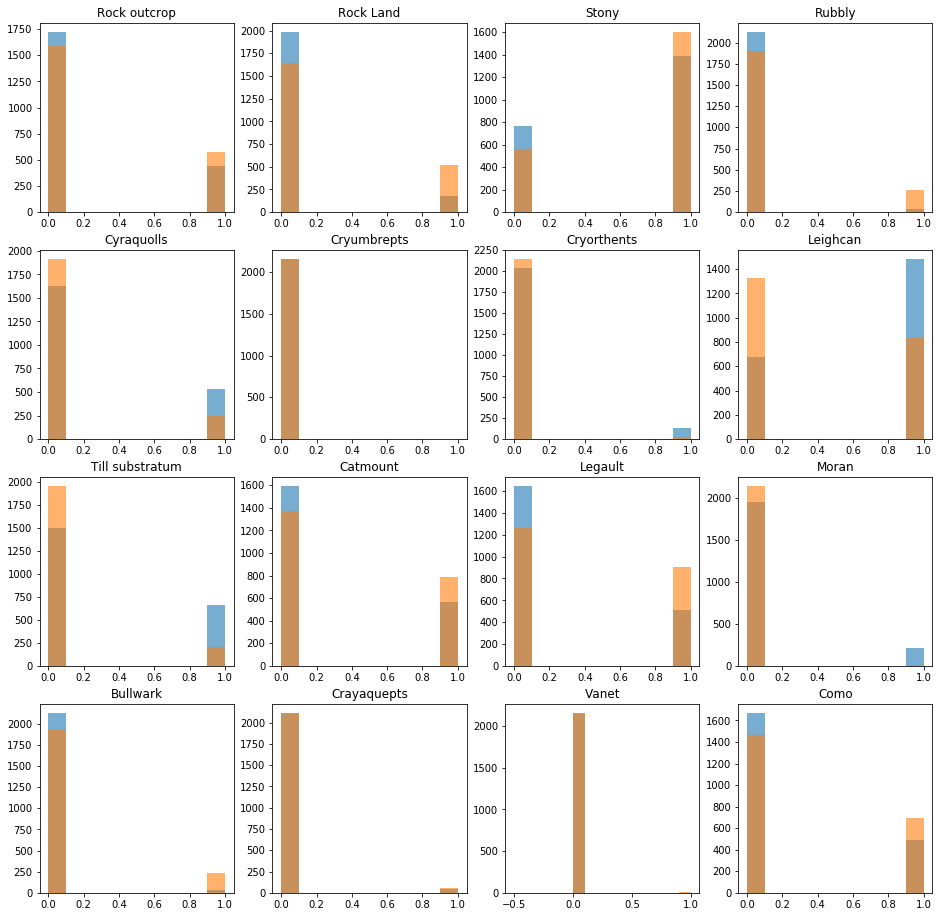

In [0]:
soil_types = [['Rock outcrop', 'Rock Land', 'Stony', 'Rubbly'], 
              ['Cyraquolls', 'Cryumbrepts','Cryorthents', 'Leighcan'], 
              ['Till substratum', 'Catmount', 'Legault', 'Moran'], 
              ['Bullwark', 'Crayaquepts', 'Vanet', 'Como']]

fig, ax = plt.subplots(4, 4, figsize=(16, 16))    
for i in range(4):
    for j in range(4):
        ax[i, j].hist(train_df2[train_df2["Cover_Type"]==1][soil_types[i][j]].reset_index(drop=True), 
                      alpha=0.6, label="Cov_1")
        ax[i, j].hist(train_df2[train_df2["Cover_Type"]==2][soil_types[i][j]].reset_index(drop=True),
                      alpha=0.6, label="Cov_2")
        ax[i, j].set_title(soil_types[i][j])

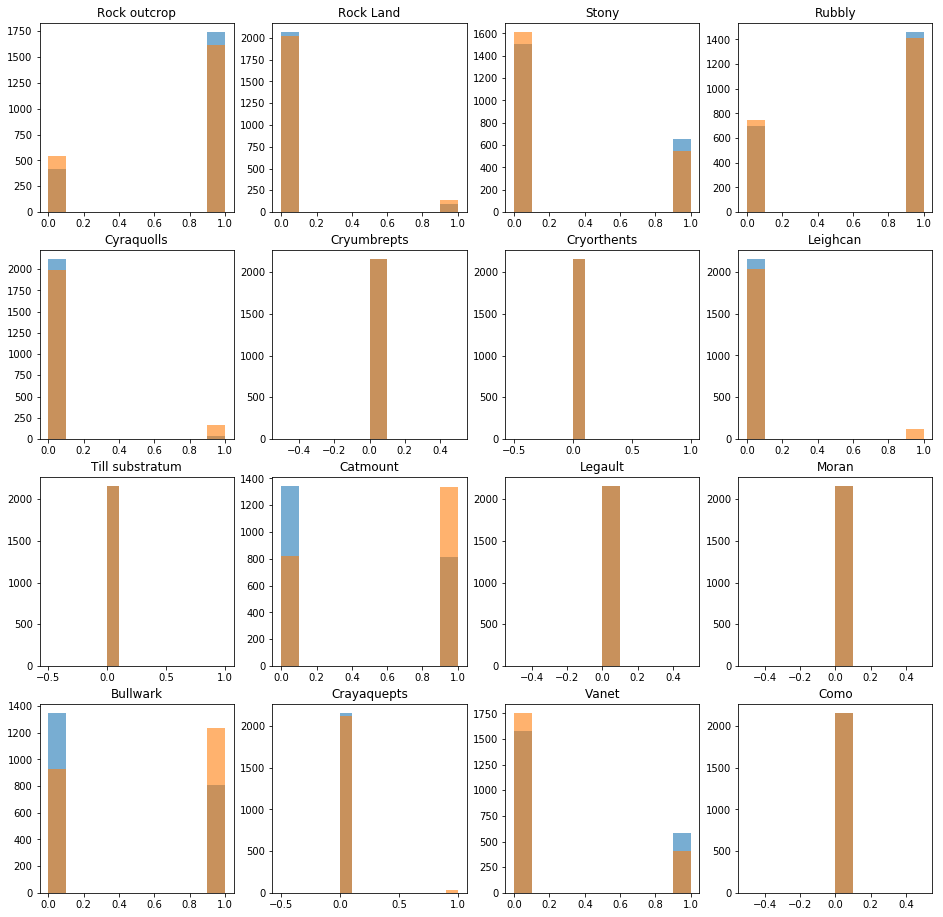

In [0]:
soil_types = [['Rock outcrop', 'Rock Land', 'Stony', 'Rubbly'], 
              ['Cyraquolls', 'Cryumbrepts','Cryorthents', 'Leighcan'], 
              ['Till substratum', 'Catmount', 'Legault', 'Moran'], 
              ['Bullwark', 'Crayaquepts', 'Vanet', 'Como']]

fig, ax = plt.subplots(4, 4, figsize=(16, 16))    
for i in range(4):
    for j in range(4):
        ax[i, j].hist(train_df2[train_df2["Cover_Type"]==3][soil_types[i][j]].reset_index(drop=True), 
                      alpha=0.6, label="Cov_1")
        ax[i, j].hist(train_df2[train_df2["Cover_Type"]==6][soil_types[i][j]].reset_index(drop=True),
                      alpha=0.6, label="Cov_2")
        ax[i, j].set_title(soil_types[i][j])

#### 3. Add new soil features that show difference in cover type 1 and 2 as well as type 3 and type 6 
- **Soil type**: add 9 new soil features; 
- remove **Soil_Type7**, **Soil_Type15**, **Horizontal_Distance_To_Hydrology**, **Hillshade_3pm**

In [0]:
### Begin Feature Engineering
# Separate continuous variables and discrete variables from train_df
train_df_cont_noLabel = train_df2.iloc[:,0:10]
train_df_disc_noLabel = train_df2.iloc[:,[10,11,12,13,15,16,17,18,21,22,23,24,25,26,29]]
train_df_cover = train_df2.iloc[:,-1]

# 1. Original Soil_Type columns
train_df_disc_noLabel_1 = train_df.iloc[:, 14:52]

# # 2. Add two new categorical variables for aspect and elevation to train_df_disc_noLabel_1
# labels_aspect = [1, 2]
# train_df_cont_noLabel['Aspect_Group'] = pd.cut(train_df_cont_noLabel.Aspect, [0, 200, 360], 
#                                                labels=labels_aspect, include_lowest=True)

# labels_elevation = [1, 2, 3]
# train_df_cont_noLabel['Elevation_Group'] = pd.cut(train_df_cont_noLabel.Elevation, [0, 2600, 3000, 3900], 
#                                                   labels=labels_elevation, include_lowest=True)

# 4. Concatenate df from step 2, df from step 3, and train_df_cover to generate new df for algo
train_df_engineered = pd.concat([train_df_cont_noLabel, train_df_disc_noLabel, 
                                 train_df_disc_noLabel_1, train_df_cover], axis = 1)

train_df_engineered2 = train_df_engineered.drop(['Horizontal_Distance_To_Hydrology', 'Hillshade_3pm'], axis = 1)

display(train_df_engineered2.head())

,Elevation,Aspect,Slope,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Rock Land,Stony,Rubbly,Cyraquolls,Leighcan,Till substratum,Catmount,Legault,Moran,Bullwark,Como,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,0,510,221,232,6279,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,-6,390,220,235,6225,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,65,3180,234,238,6121,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,118,3090,238,238,6211,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,-1,391,220,234,6172,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


#### 4. Run through selected classifiers to check for improvement

In [0]:
# Create new train_data and dev_data with second round of data engineering 
my_data = train_df_engineered2.values
train_data, dev_data, train_labels, dev_labels = data_to_np(my_data)
seed = 0

#### Random Forest Classifier

In [68]:
# Perform Random Forest Classifier with second round feature engineering
rfc = RandomForestClassifier(n_estimators=200 , max_features=20, random_state=seed, max_depth=70) 
rfc.fit(train_data, train_labels)
rfc_pred = rfc.predict(dev_data)
rfc_train_score = accuracy_score(train_labels, rfc.predict(train_data))
rfc_score = accuracy_score(dev_labels, rfc_pred)

print("\n# Random Forest Classifier with second round feature engineering:\n")
print("Training Accuracy score: %0.4f" %rfc_train_score)
print("Dev Data Accuracy score: %0.4f" %rfc_score)
print("-"*70)

# Visualization of confusion matrix

print("\n# confusion_matrix:")
confusion_matrix(dev_labels, rfc_pred)


# Random Forest Classifier with second round feature engineering:

Training Accuracy score: 1.0000
Dev Data Accuracy score: 0.8591
----------------------------------------------------------------------

# confusion_matrix:


array([[473, 118,   1,   0,  15,   2,  48],
       [113, 452,  12,   0,  57,  17,   3],
       [  0,   4, 525,  27,   6,  71,   0],
       [  0,   0,  11, 656,   0,  12,   0],
       [  3,  13,   5,   0, 623,   9,   0],
       [  0,   1,  47,  20,   1, 554,   0],
       [ 22,   1,   0,   0,   0,   0, 614]])

#### SVM Classifier

In [0]:
# Perform SVM Classifier with second round feature engineering

svm_clf = svm.SVC(C=10, kernel='rbf', gamma='scale', random_state=seed).fit(train_data, train_labels)
svm_pred = svm_clf.predict(dev_data)
svm_train_score = accuracy_score(train_labels, svm_clf.predict(train_data))
svm_score = accuracy_score(dev_labels, svm_pred)

print("# SVM Classifier with second round feature engineering:\n")
print("Training Accuracy score: %0.4f" %svm_train_score)
print("Dev Data Accuracy score: %0.4f" %svm_score)
print("-"*70)

print("\n# confusion_matrix:")
confusion_matrix(dev_labels, svm_pred)

# SVM Classifier with second round feature engineering:

Training Accuracy score: 0.6709
Dev Data Accuracy score: 0.6744
----------------------------------------------------------------------

# confusion_matrix:


array([[407, 101,   0,   0,  33,   2, 114],
       [149, 292,  18,   0, 146,  33,  16],
       [  0,   1, 258, 102,  34, 238,   0],
       [  0,   0,  46, 584,   0,  49,   0],
       [  0,  61,   9,   0, 562,  21,   0],
       [  0,   2, 143,  74,  29, 375,   0],
       [ 52,   0,   0,   0,   4,   0, 581]])

#### Adaboost Classifier with Decision Tree

In [81]:
# Perform Adaboost Classifier with Decision Tree with second round feature engineering

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15),n_estimators = 100, learning_rate = 0.5)
ada_clf.fit(train_data, train_labels)
ada_pred = ada_clf.predict(dev_data)
ada_train_score = accuracy_score(train_labels, ada_clf.predict(train_data))
ada_dev_score = accuracy_score(dev_labels, ada_pred)

print("\n# Adaboost Classifier with Decision Tree with second round feature engineering:\n")
print("Training Accuracy score: %0.4f" %ada_train_score)
print("Dev Data Accuracy score: %0.4f" %ada_dev_score)
print("-"*70)

# Visualization of confusion matrix

print("\n# confusion_matrix:")
confusion_matrix(dev_labels, ada_pred)


# Adaboost Classifier with Decision Tree with second round feature engineering:

Training Accuracy score: 1.0000
Dev Data Accuracy score: 0.8765
----------------------------------------------------------------------

# confusion_matrix:


array([[498, 112,   1,   0,  10,   1,  35],
       [107, 481,  14,   0,  32,  17,   3],
       [  0,   4, 528,  17,  11,  73,   0],
       [  0,   0,  11, 661,   0,   7,   0],
       [  1,  13,   6,   0, 626,   7,   0],
       [  0,   2,  47,  12,   3, 559,   0],
       [ 13,   1,   0,   0,   0,   0, 623]], dtype=int64)

#### 5. Conclusions & Error Analysis from Round 2 feature engineering
> Below is a table summarizing the best accuracy scores we achieved on dev data in round 2:

|        Model       |Random Forest| SVM      |DT w/ Adaboost|
|--------------------|------------:|---------:|-------------:|
|Round 2 Result      |0.8516       |0.8298    |0.8631        |
|Compared to Baseline|+3.08%       |-1.90%    |+7.08%        |
|Compared to Round 1 |+2.14%       |-3.13%    |+0.07%        |

> - We see slight improvement in terms of separating cover type 1 and 2 based off the confusion matrices of Random Forest classifier, which may be the reason of accuracy improvement in RF classifier. 
- However, As for the confusion matrix of SVM, we can see the numbers increase in cells other than type 1-vs.-2, which means that by introducing new soil features, the classifier becomes more confused over distinguishing other cover types, which as a result drawing our Dev accuracy score down.
- In addition, for SVM, we see decrease in Dev accuracy even though Train accuracy increases. It suggests that this round of feature engineering brings in overfitting issue to the classifier.  
- In our third round of feature engineering, we will address overfitting issue by PCA feature reduction. 

***

### <font color=blue> 7-5. Feature Engineering Round 3: PCA Feature Reduction </font>
> In this third round of feature engineering, we 
- Use PCA to reduce 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology' to 'Distance_To_Hydrology'
- Use PCA to reduce 'Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm' to 'Shade'
- Because horizontal distance and vertical distance to hydrology show good linear relationship, we will try to reduce the dimension of the two features to one using PCA

#### 1. Calculate explained variances after applying PCA

In [35]:
# get the train_data for principal component calculation

train_data, dev_data, train_labels, dev_labels = data_to_np(train_df.values)

In [36]:
# We explore how much variance is accounted for when PCA on distance to hydrology
pca_mod = PCA(n_components = 2)
pca_mod.fit(train_data[:,[3,4]])

print('Explained variance ratio: \n', pca_mod.explained_variance_ratio_)
print('Cumulative explained variance: \n', np.cumsum(pca_mod.explained_variance_ratio_))
# print('PCA components: \n', pca_mod.components_)

Explained variance ratio: 
 [0.95625888 0.04374112]
Cumulative explained variance: 
 [0.95625888 1.        ]


In [37]:
# calcuate the reduced data
Distance_To_Hydrology = np.dot(train_df.iloc[:,[3,4]], pca_mod.components_.T[:,:1])

In [38]:
# do the same for 'Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm' 
# since many of them exhibited pairwise linear relationships

n_comp = 5
pca_mod = PCA(n_components = n_comp)
pca_mod.fit(train_data[:,[1,2,6,7,8]])

print('Explained variance ratio: \n', pca_mod.explained_variance_ratio_)
print('Cumulative explained variance: \n', np.cumsum(pca_mod.explained_variance_ratio_))
# print('PCA components: \n', pca_mod.components_)

Explained variance ratio: 
 [8.59444514e-01 9.47010858e-02 4.29458299e-02 2.72561459e-03
 1.82955310e-04]
Cumulative explained variance: 
 [0.85944451 0.9541456  0.99709143 0.99981704 1.        ]


In [39]:
# calculate the reduced data for shade
shade_3D = np.dot(train_df.iloc[:,[1,2,6,7,8]], pca_mod.components_.T[:,:3])
shade_2D = np.dot(train_df.iloc[:,[1,2,6,7,8]], pca_mod.components_.T[:,:2])
shade_1D = np.dot(train_df.iloc[:,[1,2,6,7,8]], pca_mod.components_.T[:,:1])

#### 2. Perform feature reduction based off PCA explained variance results

In [40]:
## Begin Feature Engineering Round 5
# Separate continuous variables and discrete variables from train_df
train_df_cont_noLabel = train_df.iloc[:,:10]
train_df_disc_noLabel = train_df.iloc[:,10:52]
train_df_cover = train_df.iloc[:,52]


# Remove 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'

train_df_cont_noLabel_1 = train_df_cont_noLabel.drop(['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'], axis = 1)

# Remove 'Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'

train_df_cont_noLabel_1 = train_df_cont_noLabel_1.drop(['Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'], axis = 1)

# Add the reduced Distance_To_Hydrology to dataframe, convert to int so it's usable for all of the classifiers

train_df_cont_noLabel_1['Distance_To_Hydrology'] = Distance_To_Hydrology.astype(int)

# Add the reduced Shade data to dataframe (use 1D first), so it's usable for all of the classifiers

train_df_cont_noLabel_1['Shade'] = shade_1D.astype(int)

# Concatenate df
train_df_engineered4 = pd.concat([train_df_cont_noLabel_1, train_df_disc_noLabel, train_df_cover], axis = 1)


display(train_df_engineered4.head())

,Elevation,Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Fire_Points,Distance_To_Hydrology,Shade,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,510,6279,252,67,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,390,6225,206,73,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,3180,6121,275,144,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,3090,6211,260,155,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,391,6172,149,63,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


#### 3. Run through selected classifiers to check for improvement

In [78]:
# get the train and dev data and labels after feature engineering round 4

my_data = train_df_engineered4.values
train_data, dev_data, train_labels, dev_labels = data_to_np(my_data)

# set the random seed
seed = 0

#### Random Forest Classifier

In [79]:
# Perform Random Forest Classifier with third round feature engineering
rfc = RandomForestClassifier(n_estimators=200 , max_features=20, random_state=seed, max_depth=70)
rfc.fit(train_data, train_labels)
rfc_pred = rfc.predict(dev_data)
rfc_train_score = accuracy_score(train_labels, rfc.predict(train_data))
rfc_score = accuracy_score(dev_labels, rfc_pred)

print("\n# Random Forest Classifier with third round of feature engineering:\n")
print("Training Accuracy score: %0.4f" %rfc_train_score)
print("Dev Data Accuracy score: %0.4f" %rfc_score)
print("-"*70)

# Visualization of confusion matrix

print("\n# confusion_matrix:")
confusion_matrix(dev_labels, rfc_pred)


# Random Forest Classifier with third round of feature engineering:

Training Accuracy score: 1.0000
Dev Data Accuracy score: 0.8704
----------------------------------------------------------------------

# confusion_matrix:


array([[485, 111,   2,   0,  17,   1,  41],
       [103, 471,  13,   0,  45,  18,   4],
       [  0,   3, 530,  23,   6,  71,   0],
       [  0,   0,  15, 659,   0,   5,   0],
       [  0,  13,   3,   0, 630,   7,   0],
       [  1,   1,  51,  11,   3, 556,   0],
       [ 19,   0,   0,   0,   1,   0, 617]], dtype=int64)

#### SVM classifier

In [0]:
# Perform SVM Classifier with third round feature engineering

svm_clf = svm.SVC(C=10, kernel='rbf', gamma='scale', random_state=seed).fit(train_data, train_labels)
svm_pred = svm_clf.predict(dev_data)
svm_train_score = accuracy_score(train_labels, svm_clf.predict(train_data))
svm_score = accuracy_score(dev_labels, svm_pred)

print("# SVM Classifier with third round of feature engineering:\n")
print("Training Accuracy score: %0.4f" %svm_train_score)
print("Dev Data Accuracy score: %0.4f" %svm_score)
print("-"*70)

print("\n# confusion_matrix:")
confusion_matrix(dev_labels, svm_pred)

# SVM Classifier with third round of feature engineering:

Training Accuracy score: 0.6596
Dev Data Accuracy score: 0.6618
----------------------------------------------------------------------

# confusion_matrix:


array([[403,  98,   1,   0,  39,   1, 115],
       [141, 298,  20,   0, 145,  35,  15],
       [  0,   6, 281, 112,  25, 209,   0],
       [  0,   0,  70, 545,   0,  64,   0],
       [  6,  56,  11,   0, 560,  20,   0],
       [  0,   6, 179,  78,  35, 325,   0],
       [ 43,   3,   0,   0,   1,   0, 590]])

#### Adaboost with Decision Tree Classifier

In [82]:
# Perform Adaboost Classifier with Decision Tree with third round feature engineering

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15),n_estimators = 100, learning_rate = 0.5)
ada_clf.fit(train_data, train_labels)
ada_pred = ada_clf.predict(dev_data)
ada_train_score = accuracy_score(train_labels, ada_clf.predict(train_data))
ada_dev_score = accuracy_score(dev_labels, ada_pred)

print("\n# Adaboost Classifier with Decision Tree with third round of feature engineering:\n")
print("Training Accuracy score: %0.4f" %ada_train_score)
print("Dev Data Accuracy score: %0.4f" %ada_dev_score)
print("-"*70)

# Visualization of confusion matrix

print("\n# confusion_matrix:")
confusion_matrix(dev_labels, ada_pred)


# Adaboost Classifier with Decision Tree with third round of feature engineering:

Training Accuracy score: 1.0000
Dev Data Accuracy score: 0.8748
----------------------------------------------------------------------

# confusion_matrix:


array([[498, 107,   1,   0,  12,   2,  37],
       [112, 470,  14,   0,  38,  16,   4],
       [  0,   5, 531,  22,   6,  69,   0],
       [  0,   0,  14, 661,   0,   4,   0],
       [  4,  13,   5,   0, 625,   6,   0],
       [  0,   2,  43,  11,   4, 563,   0],
       [ 16,   0,   0,   0,   1,   0, 620]], dtype=int64)

#### 4. Conclusions & Error Analysis from Round 3 feature engineering
> Below is a table summarizing the best accuracy scores we achieved on dev data in round 3:

|        Model       |Random Forest| SVM      |DT w/ Adaboost|
|--------------------|------------:|---------:|-------------:|
|Round 3 Result      |0.8746       |0.8479    |0.8805        |
|Compared to Baseline|+5.38%       |-0.09%    |+8.82%        |
|Compared to Round 1 |+4.44%       |-1.32%    |+1.81%        |
|Compared to Round 2 |+2.30%       |-1.81%    |+1.74%        |

> - From the confusion matrices of Random Forest and Adaboost classifier, although Type 1 and 2 are still hard to classify, the confusion in classifying other types (especially Type 3 and 6) reduces. This may explain the improvement in accuracy in these two classifiers. 
- Whereas for SVM, its best performance is achieved in Round 1, where Aspect and Elevation play a stronger weights in classification. To further improve SVM performance, we believe we need to further engineer/transform these two variables. 

***

#### 5. Final hyper-parameter tuning with Random Forest

In [ ]:
param_grid = {
    'max_depth': [70, 80, 90, 100, None],
    'max_features': [10, 20, 30],
    'n_estimators': [50, 100, 200, 500]
}
# Create a based model
rfc = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search.fit(train_data, train_labels)
grid_search.best_params_

##### 6. Final hyper-parameter tuning with DT w/ Adaboost

Additional note: through some manual tests, we found that add max_features = 20 in our base tree generally gives us better accuracy on dev data; therefore, we will add it into our decision tree for the tuning here

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.5, 0.1, 0.05]
}
# Create a based model
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15, max_features=20))

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = ada_clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search.fit(train_data, train_labels)
grid_search.best_params_

## 8. Submitting Predictions on Test Data to Kaggle

In [ ]:
test_df = pd.read_csv('test.csv') # load test data

In [51]:
# Dropping Soil_Type7 and Soil_Type15 from test_df and separate ID from the features for prediction
test_ID = test_df.Id
test_df_clean = test_df.drop(['Id', 'Soil_Type7', 'Soil_Type15'], axis = 1)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2680,354,14,0,0,2684,196,214,156,6645,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2683,0,13,0,0,2654,201,216,152,6675,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2713,16,15,0,0,2980,206,208,137,6344,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2709,24,17,0,0,2950,208,201,125,6374,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2706,29,19,0,0,2920,210,195,115,6404,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [58]:
# Apply feature engineering 3 (PCA) on the test data

train_data, dev_data, train_labels, dev_labels = data_to_np(train_df.values)

df_to_engineer = test_df_clean

pca_mod = PCA(n_components = 2)
pca_mod.fit(train_data[:,[3,4]])
# calcuate the reduced data
Distance_To_Hydrology = np.dot(df_to_engineer.iloc[:,[3,4]], pca_mod.components_.T[:,:1])

pca_mod = PCA(n_components = 5)
pca_mod.fit(train_data[:,[1,2,6,7,8]])
shade_1D = np.dot(df_to_engineer.iloc[:,[1,2,6,7,8]], pca_mod.components_.T[:,:1])

engineered_df_cont_noLabel = df_to_engineer.iloc[:,:10]
engineered_df_disc_noLabel = df_to_engineer.iloc[:,10:52]

# Remove 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'

engineered_df_cont_noLabel = engineered_df_cont_noLabel.drop(['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'], axis = 1)

# Remove 'Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'

engineered_df_cont_noLabel = engineered_df_cont_noLabel.drop(['Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'], axis = 1)

# Add the reduced Distance_To_Hydrology to dataframe, convert to int so it's usable for all of the classifiers

engineered_df_cont_noLabel['Distance_To_Hydrology'] = Distance_To_Hydrology.astype(int)

# Add the reduced Shade data to dataframe (use 1D first), so it's usable for all of the classifiers

engineered_df_cont_noLabel['Shade'] = shade_1D.astype(int)

# Concatenate df
engineered_test_df = pd.concat([engineered_df_cont_noLabel, engineered_df_disc_noLabel], axis = 1)

In [83]:
# Use the tuned Random Forest and Adaboost with Decision Trees to predict the samples on test and submit at Kaggle

my_data = train_df_engineered4.values
train_data, dev_data, train_labels, dev_labels = data_to_np(my_data)

# predict with RF and save the results

rfc = RandomForestClassifier(n_estimators=200 , max_features=20, max_depth=80)
rfc.fit(train_data, train_labels)
rfc_pred = rfc.predict(engineered_test_df.values)

rfc_test_pred = pd.DataFrame({'Id': test_ID,
                              'Cover_Type': rfc_pred})
rfc_test_pred.to_csv('rfc_test_pred.csv' ,index=False)

# predict with Adaboost and save the results

ada_test_pred = pd.DataFrame({'Id': test_ID,
                              'Cover_Type': ada_pred})
ada_test_pred.to_csv('ada_test_pred.csv' ,index=False)

## 9. Conclusions and Future Improvement

###  <font color=blue> 9-1. Test Results on Kaggle </font>  
> We run our feature engineering and classifiers on test.csv, and submit our predictions to Kaggle. Below is a summary of our results:

|        Model       |Random Forest| SVM      |DT w/ Adaboost|
|--------------------|------------:|---------:|-------------:|
|Kaggle Test Result  |0.74053       |0.????    |0.76074        |


### <font color=blue> 9-2. Lessons Learned </font>  
* To be inserted...


### <font color=blue> 9-3. Future Improvements </font>  
* One future improvement plan that might help improving the accuracy on test data is blending of the different ensemble models we built. Just as how a collection of classifiers has the potential to outperform any individual in the collection alone. It's possible a tuned blending of ensembles can have better accuracy than individual ensemble classifier. We noticed that though adaboost of decision trees has the highest overall accuracy but it mainly comes from successfully distinguishing the second most confusing pairs (pair of type 3 and type 6). In some cases, the SVM and Random Forest performed better at disambiguating type 1 and type 2 which is the major challenge in this problem. Therefore, it is worth to explore if any combination of our current ensembles can give us improvement on test data prediction.